# Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


# Import packages (some are not used)

In [3]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

# Load data

In [4]:
#load data
data=pd.read_csv('/gdrive/MyDrive/Colab Notebooks/Data Sets/AMZN.csv', delimiter=',')
data.info()
#remove columns we dont need
data = data.drop(data.columns[[2, 3, 4, 5]], axis=1)
#fill missing values
data['Open'].interpolate(method='index', inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Open    1259 non-null   float64
 2   Volume  1259 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 29.6+ KB


<Figure size 432x288 with 0 Axes>

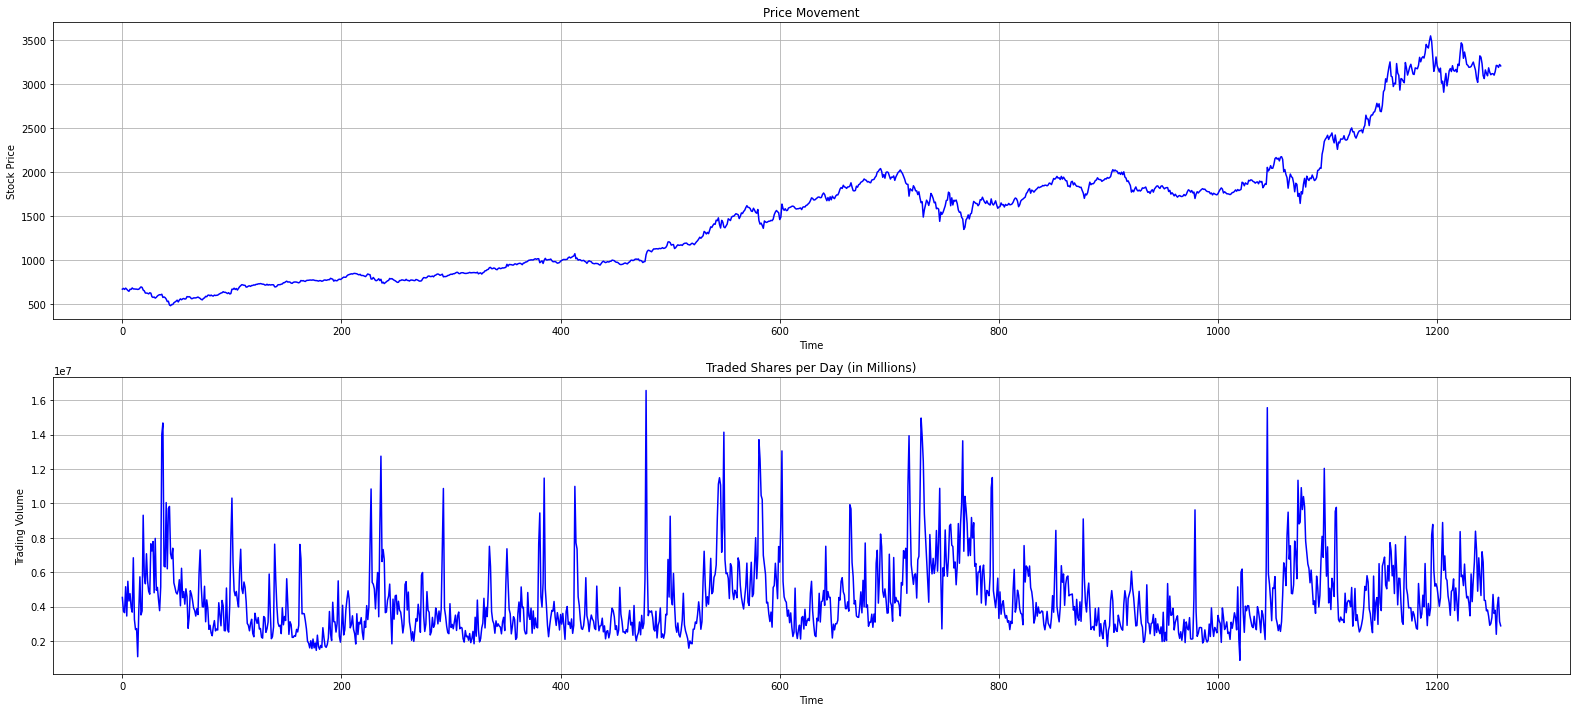

In [16]:
plt.clf()
fig = plt.figure(figsize=(22, 10))

plt.subplot(211)
plt.plot(data['Open'], color='b')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Price Movement')
plt.grid()

plt.subplot(212)
plt.plot(data['Volume'], color='b')
plt.xlabel('Time')
plt.ylabel('Trading Volume')
plt.title('Traded Shares per Day (in Millions)')

plt.tight_layout()
plt.grid()
plt.show()

# Split data

In [5]:
#split 80/20
training_size = int(0.8*len(data))
#input is previous price and previous volume
x_train = data.iloc[0:training_size-1, 1:3].values
x_test = data.iloc[training_size:-1, 1:3].values
#output is only next price
y_train = data.iloc[1:training_size, 1:2].values
y_test = data.iloc[training_size+1:, 1:2].values

print(x_train[1, :])#first value is price, second value is volume
print(y_train[0, :])#shifted y_training data by 1
print(np.shape(x_train))
print(np.shape(y_train))
print(np.shape(x_test))


[6.7473999e+02 3.7328000e+06]
[674.73999]
(1006, 2)
(1006, 1)
(251, 2)


# Normalize data

In [6]:
#### Normalization: 
    # Normalization AFTER splitting data 
    #As with all the transformations, it is important 
    #to fit the scalers to the training data only, 
    #not to the full dataset (including the test set). 
    #Only then can you use them to transform the training 
    #set and the test set (and new data).
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

print(np.shape(x_train_scaled))
print(np.shape(y_train_scaled))
print(np.shape(x_test_scaled))

(1006, 2)
(1006, 1)
(251, 2)


# Construct LSTM

In [7]:
#LSTM input layer must be 3D, meaning (samples, time steps, features)

## creating a data structure with 1 time-step and 1 output

x_train_scaled = np.reshape(x_train_scaled, (x_train_scaled.shape[0], 1, x_train_scaled.shape[1]))
x_test_scaled = np.reshape(x_test_scaled, (x_test_scaled.shape[0], 1, x_test_scaled.shape[1]))

print(np.shape(x_train_scaled))
print(np.shape(x_test_scaled))
print(np.shape(y_train_scaled))

(1006, 1, 2)
(251, 1, 2)
(1006, 1)


In [8]:
np.random.seed(123)
tf.random.set_seed(123)

In [9]:
#from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='auto')

#create model
model = Sequential()
model.add(LSTM(50, input_shape = (x_train_scaled.shape[1], x_train_scaled.shape[2]), return_sequences=True))
model.add(LSTM(10, dropout=0.2))
model.add(Dense(2, activation='relu'))#dense layer compresses input to output 
model.add(Dense(1, activation='relu'))#dense layer compresses input to output 
model.compile(optimizer='adam', loss='mse', metrics=['acc'])
#opt = tf.keras.optimizers.Adam(clipnorm=1.0)#for exploding gradient problem
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10600     
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                2440      
_________________________________________________________________
dense (Dense)                (None, 2)                 22        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 13,065
Trainable params: 13,065
Non-trainable params: 0
_________________________________________________________________


# Fit model on training data

In [10]:
#fit model to training data
history = model.fit(x_train_scaled, y_train_scaled, 
            epochs=21, batch_size=25,#how many times do we run the model and how many instances do we pass each step (32 is general starting point, generally start with 32/64/128/256/1024)
            validation_split = 0.1, #splits training data into another validation set
            verbose=1) #returns state for each epoche

Epoch 1/21
37/37 [==============================] - 1s 24ms/step - loss: 0.2280 - acc: 0.0011 - val_loss: 0.4222 - val_acc: 0.0000e+00
Epoch 2/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0909 - acc: 0.0011 - val_loss: 0.0890 - val_acc: 0.0000e+00
Epoch 3/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0386 - acc: 0.0022 - val_loss: 0.0427 - val_acc: 0.0000e+00
Epoch 4/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0254 - acc: 0.0022 - val_loss: 0.0194 - val_acc: 0.0000e+00
Epoch 5/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0140 - acc: 0.0022 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 6/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0061 - acc: 0.0022 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 7/21
37/37 [==============================] - 0s 3ms/step - loss: 0.0036 - acc: 0.0022 - val_loss: 4.7767e-04 - val_acc: 0.0000e+00
Epoch 8/21
37/37 [==============================] - 0s 3m

# Get forecast from test data

In [11]:
#get forecast from applying model to test data
prediction = model.predict(x_test_scaled)
x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], x_test_scaled.shape[2]))
prediction = y_scaler.inverse_transform(prediction)

# Visualize model Performance

<Figure size 432x288 with 0 Axes>

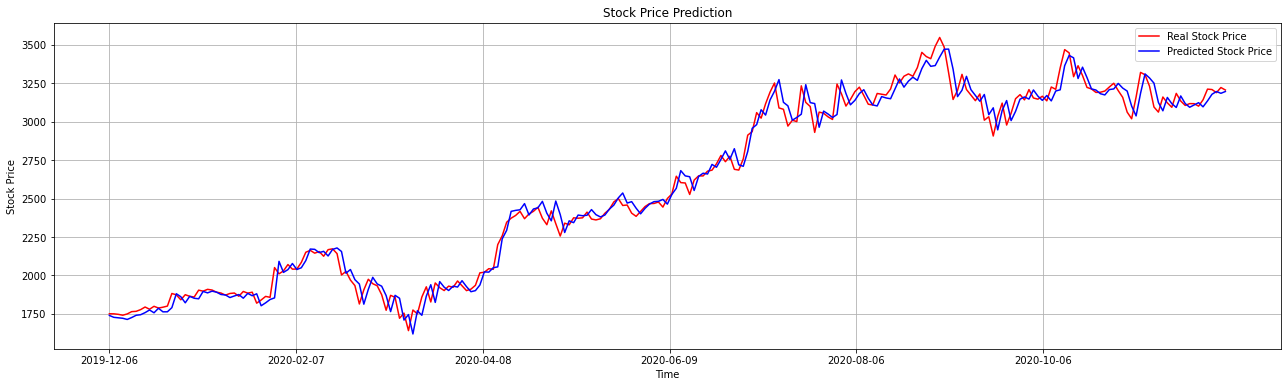

In [12]:
# Visualizing the results
time = data.loc[training_size+1:, 'Date']#plot all available points, e.g. for last 30days use [-30:] and adjust y_test and prediction accordingly when calling the plot

plt.clf()
fig = plt.figure(figsize=(22, 6))

plt.plot(time, y_test, color = 'r', label = 'Real Stock Price')
plt.plot(time, prediction, color = 'b', label = 'Predicted Stock Price')
plt.xticks(np.arange(0,len(time),len(time)/6))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.grid()
plt.legend()
plt.show()

<Figure size 432x288 with 0 Axes>

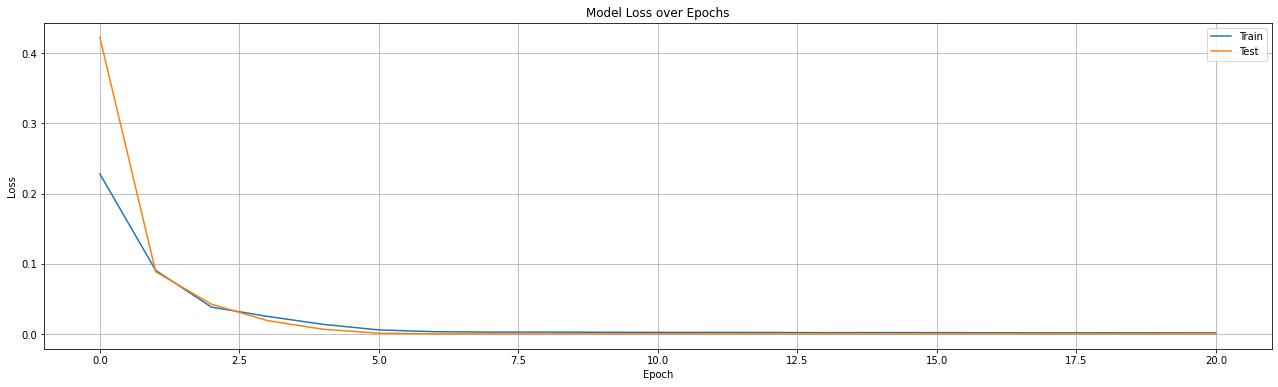

In [17]:
plt.clf()
fig = plt.figure(figsize=(22, 6))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')

plt.title('Model Loss over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()